# Introdução

Este notebook contém a pipeline para o processamento do dataset [Fake and Real News Dataset](https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset/data).

Os dados são obtidos do Kaggle e passam por normalização, análise exploratória e pré-processamento.



# Setup inicial




### Importação das bibliotecas necessárias.

In [4]:
from DataLoading.get_dataset import DataLoading
from DataEngineering.normalize import DataNormalize
from Analysis.data_distribution import DataDistribution
from Analysis.data_size import DataSizeAnalysis
from Analysis.words_cloud import WordCloudGenerator
from DataEngineering.preprocessing import DataPreprocessing
from Model.model_trainer import ModelTrainer
from Evaluation.validation import NewsEvaluator

from Settings.keys import ParamsKeys

import pandas as pd
import os
from sklearn.model_selection import train_test_split
from collections import Counter
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


### Carregamento da base de dados



In [5]:
downloader = DataLoading(ParamsKeys.DATASET_URL_DOWNLOAD)
downloader.download()

df_true = pd.read_csv(os.path.join(ParamsKeys.DATASET_FOLDER_PATH, 'True.csv'))
df_false = pd.read_csv(os.path.join(ParamsKeys.DATASET_FOLDER_PATH, 'Fake.csv'))

Dataset URL: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset
Dataset 'clmentbisaillon/fake-and-real-news-dataset' baixado com sucesso em './Dataset'.


#### Notícias verdadeiras

In [5]:
display(df_true.head())

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


#### Notícias falsas

In [6]:
display(df_false.head())

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


# Normalização


- As colunas 'title' e 'text' foram combinadas para facilitar as análises e o treinamento
- Adicionada uma coluna chamada 'status' que indica se a notícia é verdadeira (0) ou falsa (1)
- Unifica a base de dados
- Remove caracteres especiais, número e espaços extras
- Converte todas as letras para minúsculo

In [6]:
normalizer = DataNormalize(ParamsKeys.TRUE_DATASET_PATH, ParamsKeys.FAKE_DATASET_PATH)
df_processed = normalizer.merge_data()
normalizer.save_processed_data()


Arquivo salvo como: Dataset/processed/Normalized.csv


### Verificação de valores nulos

- Não há nenhum valor ausente no conjunto de dados.

In [8]:
df_processed.isnull().sum()

text       0
status     0
subject    0
dtype: int64

### Pré visualização da base transformada





In [9]:
df_processed.head()

,text,status,subject
0,former us attorney its very clear intel conspi...,0,politics
1,flash floods kill five in malaysia army deploy...,1,worldnews
2,judge jeanine pirro mitt romney awoke a sleepi...,0,politics
3,watch tucker carlson destroys leftist professo...,0,politics
4,zimbabwe opposition rejects postmugabe coaliti...,1,worldnews


# Análise exploratória

## Distribuição de variáveis

### Distribuição de categoria das notícias

De acordo com o grafico gerado, as verdadeiras concentram-se em assuntos relacionados a política e notícias globais. Em contrapartida, o gráfico das notícias falsas revela uma diversidade maior de categorias, abrangendo temas relacionados ao governo, aos Estados Unidos e ao espectro político da esquerda

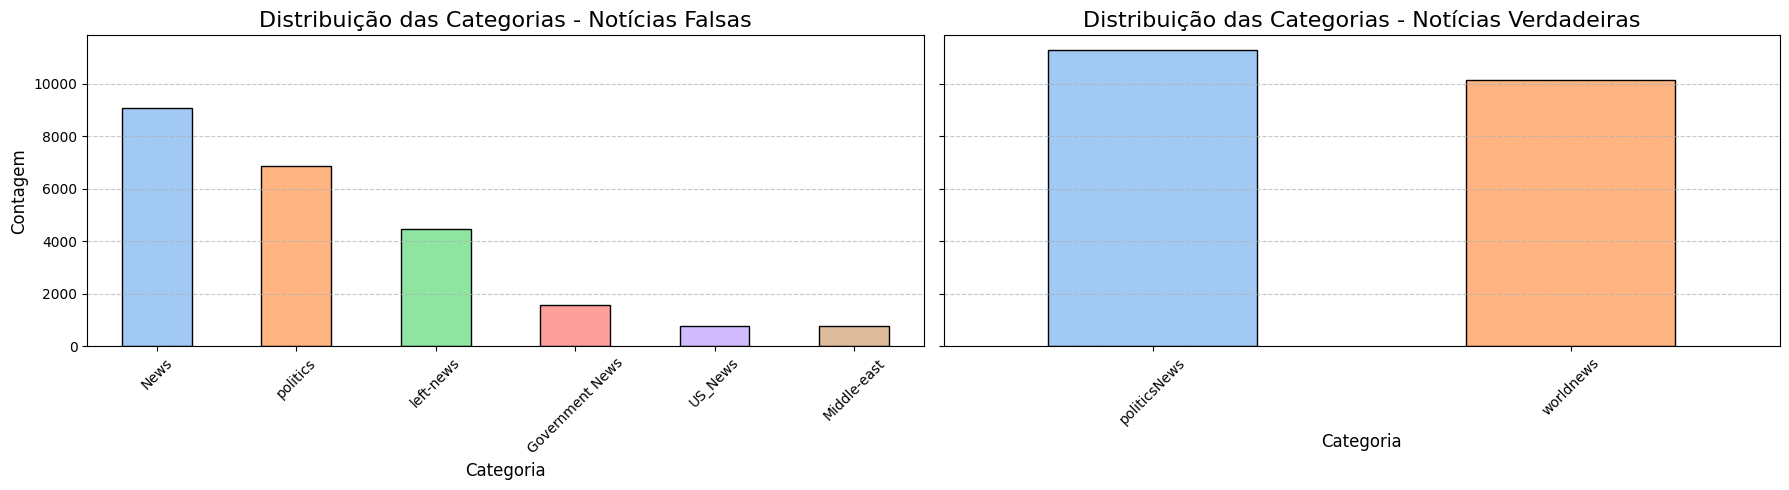

In [10]:
analysis = DataDistribution(ParamsKeys.TRUE_DATASET_PATH, ParamsKeys.FAKE_DATASET_PATH, ParamsKeys.NORMALIZED_DATASET_PATH)
analysis.plot_category_distribution()

### Distribuição da variável alvo

A partir da representação gráfica gerada, é possível ver que a base de dados possui um leve desbalanceamento na variável alo *status*.

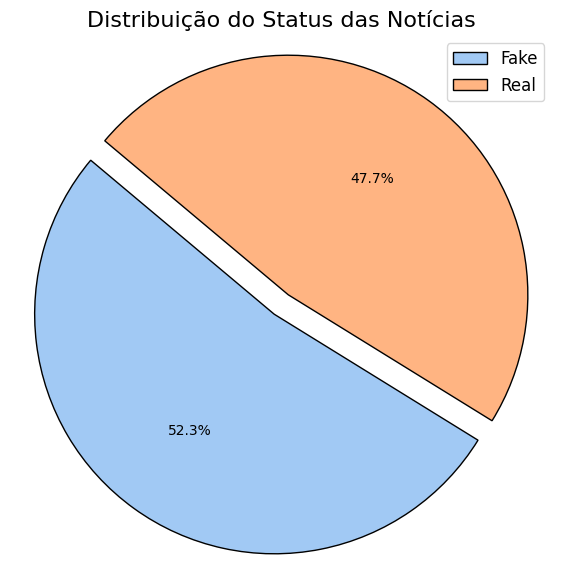

In [11]:
analysis.plot_status_distribution()

### Comprimento das notícias



#### Média de caractéres por notícia

- Os caracteres processados diminuiram em relação aos brutos
- Este comportamento é resultado da etapa de normalização dos dados

In [12]:
analysis = DataSizeAnalysis(ParamsKeys.TRUE_DATASET_PATH, ParamsKeys.FAKE_DATASET_PATH, ParamsKeys.NORMALIZED_DATASET_PATH)
analysis.calculate_avg_characters()

╒════════════════════════════════════╤═══════════════════════╕
│ Categoria                          │ Média de Caracteres   │
╞════════════════════════════════════╪═══════════════════════╡
│ Notícias Verdadeiras - Brutas      │ 2383.28 caracteres    │
├────────────────────────────────────┼───────────────────────┤
│ Notícias Falsas - Brutas           │ 2547.40 caracteres    │
├────────────────────────────────────┼───────────────────────┤
│ Notícias Verdadeiras - Processadas │ 2372.19 caracteres    │
├────────────────────────────────────┼───────────────────────┤
│ Notícias Falsas - Processadas      │ 2561.46 caracteres    │
╘════════════════════════════════════╧═══════════════════════╛


#### Histograma

Os gráficos apresentados mostram a distribuição do comprimento das notícias (em número de palavras) antes e depois do processamento, com os valores transformados para a escala logarítmica.


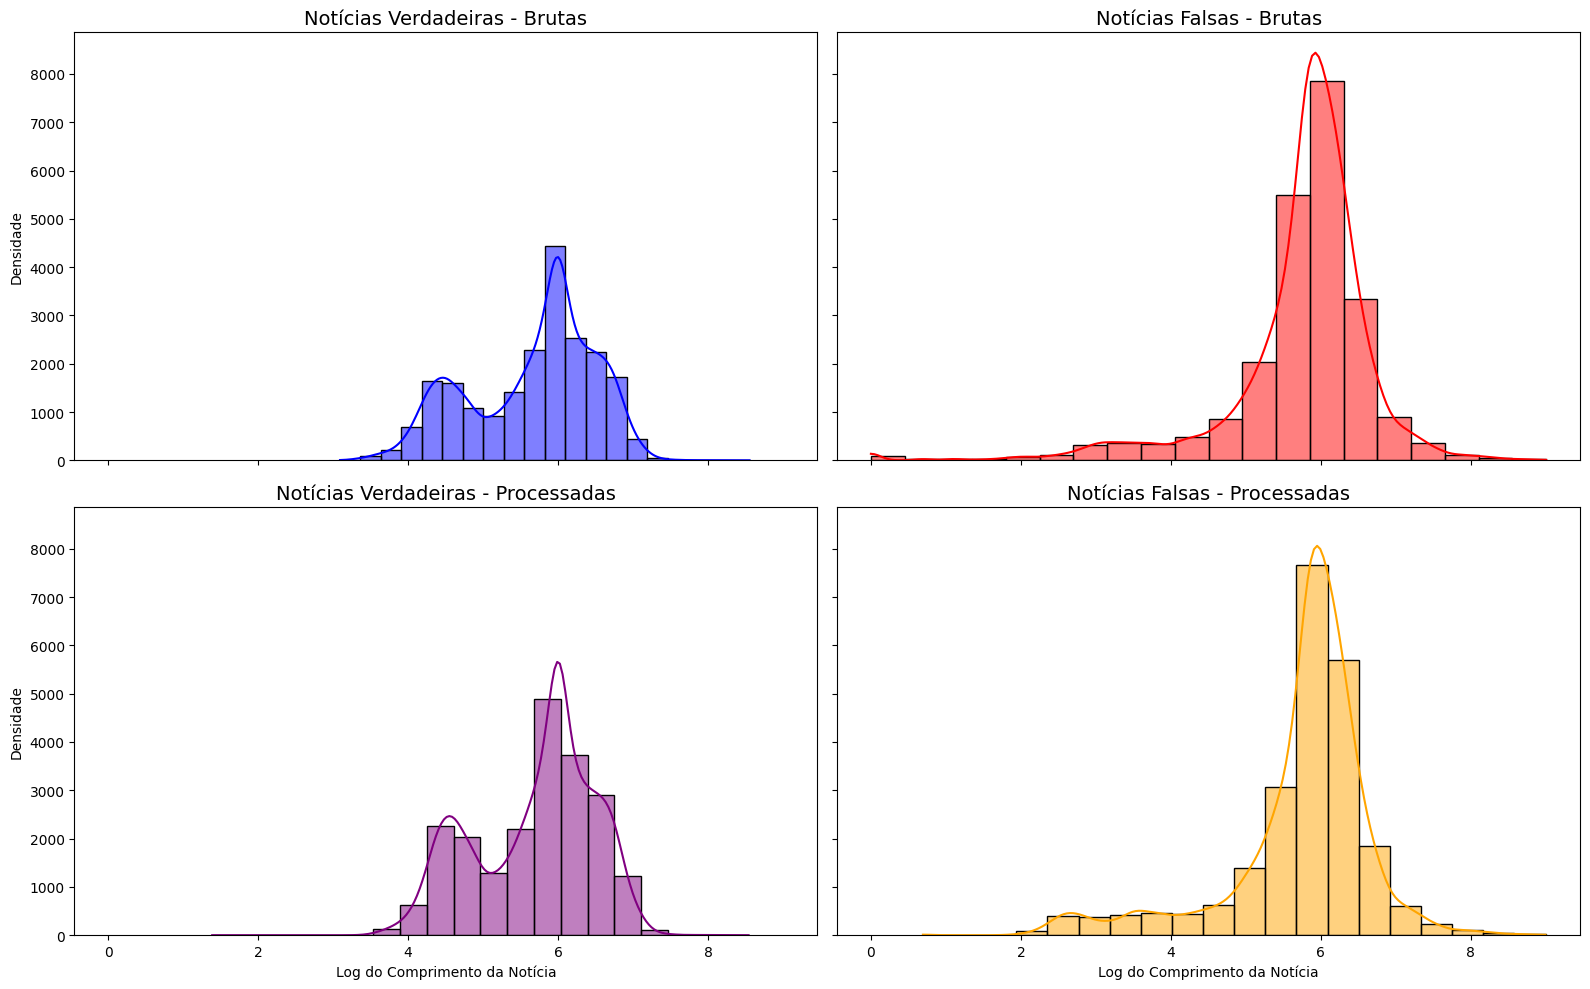

In [13]:
analysis.plot_length_distribution()

## Nuvem de palavras

De acordo com a nuvem de palaras geradas, é possível notar que as notícias verdadeiras geralmente apresentam termos relacionados à política e governo, com ênfase em datas e cronologia, além de seguirem uma estrutura narrativa baseada em eventos e discursos de figuras políticas. Já as notícias falsas tendem a usar um tom mais opinativo e persuasivo, com menor presença de fontes jornalísticas.

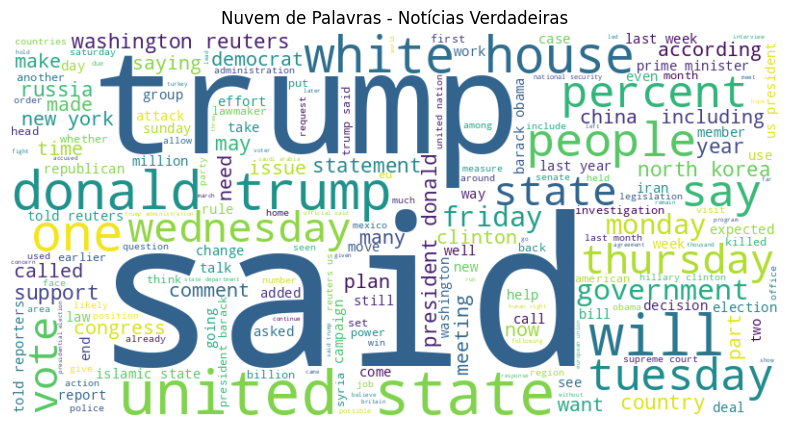

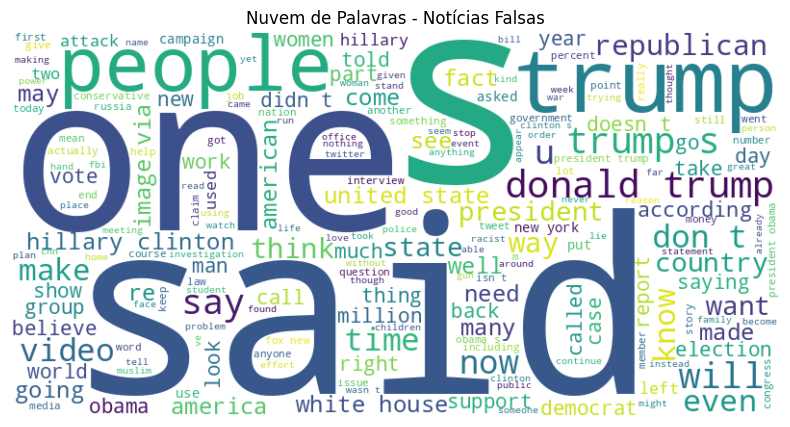

In [14]:
wordcloud_gen = WordCloudGenerator(ParamsKeys.NORMALIZED_DATASET_PATH)
wordcloud_gen.generate_fake_and_real_wordclouds()

# Pré processamento

O pré-processamento dos dados seguiu uma abordagem estruturada para garantir a qualidade e eficiência no treinamento do modelo. As etapas implementadas foram:

### Divisão da base de dados
- Primeira divisão: 80% para treino + validação, 20% para teste
- Segunda divisão: separando treino e validação

In [8]:
X = df_processed[ParamsKeys.TEXT].values
y = df_processed[ParamsKeys.STATUS].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


print("Treino:", Counter(y_train))
print("Validação:", Counter(y_val))
print("Teste:", Counter(y_test))

Treino: Counter({np.int64(0): 18785, np.int64(1): 17133})
Validação: Counter({np.int64(0): 2348, np.int64(1): 2142})
Teste: Counter({np.int64(0): 2348, np.int64(1): 2142})


### Tokenrização

In [9]:

def tokenize_and_pad(X_train, X_val, X_test):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(X_train)

  train_seq = tokenizer.texts_to_sequences(X_train)
  val_seq = tokenizer.texts_to_sequences(X_val)
  test_seq = tokenizer.texts_to_sequences(X_test)

  vocab_size = len(tokenizer.word_index) + 1
  max_length = max(len(sequence) for sequence in train_seq)

  train_seq = pad_sequences(train_seq, maxlen=max_length, padding='post', truncating='post')
  val_seq = pad_sequences(val_seq, maxlen=max_length, padding='post', truncating='post')
  test_seq = pad_sequences(test_seq, maxlen=max_length, padding='post', truncating='post')

  return train_seq, val_seq, test_seq, vocab_size, max_length

train_seq, val_seq, test_seq, vocab_size, max_length = tokenize_and_pad(X_train, X_val, X_test)

### Otimização

 Após a tokenização, os dados foram transformados em um formato otimizado para treinamento utilizando a API `tf.data.Dataset`, com operações de cache, embaralhamento, batching e prefetching, melhorando a eficiência computacional do treinamento.

In [10]:
def create_tf_dataset(X, y, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    return dataset.cache().shuffle(len(X)).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

train_dataset = create_tf_dataset(train_seq, y_train)
val_dataset = create_tf_dataset(val_seq, y_val)
test_dataset = create_tf_dataset(test_seq, y_test)

2025-03-05 19:33:13.358598: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-03-05 19:33:13.359555: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1157565304 exceeds 10% of free system memory.


# Modelo

## Instancicação do modelo
O modelo segue uma arquitetura com camadas de *embedding*, *dropout* e *pooling*

- Cria um modelo de rede neural para detecção de notícias falsas.
- Define hiperparâmetros como vocab_size (tamanho do vocabulário) e max_length (tamanho máximo das sequências).

In [11]:
embedding_dim = 16
num_classes = 2

model = tf.keras.Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='sigmoid')
])

/var/www/html/fake-and-real-news/venv/lib64/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


## Compilação do modelo
Foram definidas a função de perda, o otimizador e as métricas:


In [12]:
model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy']
)

model.build(input_shape=(None, max_length))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 8057, 16)       │     3,113,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8057, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,113,346 (11.88 MB)

 Trainable params: 3,113,346 (11.88 MB)

 Non-trainable params: 0 (0.00 B)

## Treinamento do modelo

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

epochs = 10

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/10


2025-03-05 19:33:26.867774: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1157565304 exceeds 10% of free system memory.


1123/1123 ━━━━━━━━━━━━━━━━━━━━ 64s 55ms/step - accuracy: 0.5325 - loss: 0.6945 - val_accuracy: 0.5376 - val_loss: 0.6630
Epoch 2/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 58s 51ms/step - accuracy: 0.5961 - loss: 0.6634 - val_accuracy: 0.5641 - val_loss: 0.6004
Epoch 3/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 58s 51ms/step - accuracy: 0.7127 - loss: 0.5843 - val_accuracy: 0.8532 - val_loss: 0.4529
Epoch 4/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 58s 51ms/step - accuracy: 0.8159 - loss: 0.4501 - val_accuracy: 0.7626 - val_loss: 0.4209
Epoch 5/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 58s 51ms/step - accuracy: 0.8517 - loss: 0.3620 - val_accuracy: 0.8724 - val_loss: 0.2892
Epoch 6/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 58s 52ms/step - accuracy: 0.8867 - loss: 0.2880 - val_accuracy: 0.9670 - val_loss: 0.2180
Epoch 7/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 58s 51ms/step - accuracy: 0.8976 - loss: 0.2594 - val_accuracy: 0.9160 - val_loss: 0.2055
Epoch 8/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 58s 52ms/step - accuracy: 0.9226 - loss: 0.21

# Avaliação

## Relatório de métricas

In [14]:
evaluator = NewsEvaluator(model, history)
evaluator.evaluate(train_dataset, y_train, test_dataset, y_test, val_dataset, y_val)

Acurácia de treino: 91.91%
Acurácia de teste: 92.61%
Acurácia de validação: 91.49%

Relatóro de classificação de treino: 

              precision    recall  f1-score   support

           0       0.99      0.85      0.92     18785
           1       0.86      0.99      0.92     17133

    accuracy                           0.92     35918
   macro avg       0.93      0.92      0.92     35918
weighted avg       0.93      0.92      0.92     35918

-----------------------------------------------------

Relatóro de classificação de teste: 

              precision    recall  f1-score   support

           0       1.00      0.86      0.92      2348
           1       0.87      1.00      0.93      2142

    accuracy                           0.93      4490
   macro avg       0.93      0.93      0.93      4490
weighted avg       0.94      0.93      0.93      4490

-----------------------------------------------------

Relatóro de classificação de validação: 

              precision    recall

### Treino

- 15.981 verdadeiros positivos
- 17.033 verdadeiros negativos
- 2.804 falsos positivos
- 100 falsos negativos

Baixo número de falsos negativos indica boa sensibilidade para a classe "Verdadeiro"

### Teste

- 2.023 verdadeiros positivos
- 2.135 verdadeiros negativos
- 325 falsos positivos
- 7 falsos negativos


Baixa taxa de falsos negativos reforça a capacidade do modelo de identificar corretamente a classe "Verdadeiro".

# Conclusão

O modelo de detecção de fake news alcançou um bom desempenho, com acurácia superior a 91% em todas as fases (treino, teste e validação). A precisão e o recall para ambas as classes foram equilibrados, demonstrando capacidade de identificar tanto notícias falsas quanto verdadeiras com eficácia.


## Limitações

- Apesar da alta acurácia, o modelo ainda apresenta falsos positivos e falsos negativos, o que pode comprometer a confiabilidade em cenários reais
- Pode ser sensível a viéses nos dados de treinamento, limitando a generalização para novos domínios


## Trabalhos futuros:

- Explorar técnicas de NLP avançadas, como transformers, para melhorar a detecção
- Ampliar o dataset com fontes mais diversas para reduzir viés